In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 76.5 MB/s eta 0:00:00


## Download the Indiana LANDSAT Datasets

In [ ]:
!wget https://raw.githubusercontent.com/SpatialTurn/DataCollection-Notebooks/main/Census/landsat/band1.TIF # band 1
!wget https://raw.githubusercontent.com/SpatialTurn/DataCollection-Notebooks/main/Census/landsat/band2.TIF # band 2
!wget https://raw.githubusercontent.com/SpatialTurn/DataCollection-Notebooks/main/Census/landsat/band3.TIF # band 3
!wget https://raw.githubusercontent.com/SpatialTurn/DataCollection-Notebooks/main/Census/landsat/band4.TIF # band 4
!wget https://raw.githubusercontent.com/SpatialTurn/DataCollection-Notebooks/main/Census/landsat/band5.TIF # band 5

In [2]:
# standard imports
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import Polygon, mapping

# sklearn for classification
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# display settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

### Inspect the raster file / read bands

In [12]:
!wget https://raw.githubusercontent.com/SpatialTurn/DataCollection-Notebooks/main/Census/landsat/example.tiff # dummy image

--2025-11-21 19:01:41--  https://raw.githubusercontent.com/SpatialTurn/DataCollection-Notebooks/main/Census/landsat/example.tiff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1131930 (1.1M) [image/tiff]
Saving to: ‘example.tiff’

example.tiff        100%[===================>]   1.08M  6.71MB/s    in 0.2s    

2025-11-21 19:01:42 (6.71 MB/s) - ‘example.tiff’ saved [1131930/1131930]



In [13]:
# Path to your multispectral raster (example)
raster_path = "example.tiff"

# Open with rasterio and inspect
with rasterio.open(raster_path) as src:
    print("Driver:", src.driver)
    print("CRS:", src.crs)
    print("Width, Height:", src.width, src.height)
    print("Count (bands):", src.count)
    print("Dtype:", src.dtypes)
    print("Bounds:", src.bounds)
    print("Transform:", src.transform)

    # list available band indexes
    bands = list(range(1, src.count + 1))
    print("Band indexes:", bands)

Driver: GTiff
CRS: None
Width, Height: 650 434
Count (bands): 4
Dtype: ('uint8', 'uint8', 'uint8', 'uint8')
Bounds: BoundingBox(left=0.0, bottom=434.0, right=650.0, top=0.0)
Transform: | 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|
Band indexes: [1, 2, 3, 4]


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


### Read Red and NIR bands

In [14]:
# SET THESE: change according to your dataset
# Example for many common datasets:
# - For Landsat 8: red ~ band 4, nir ~ band 5
# - For Sentinel 2 L2A: red ~ band 4, nir ~ band 8
# - For this dataset (assuming last band is NIR and second to last is red):
red_band_index = 3 # Assuming band 3 is red
nir_band_index = 4 # Assuming band 4 is NIR

with rasterio.open(raster_path) as src:
    # Read red and NIR bands
    red = src.read(red_band_index).astype('float32')
    nir = src.read(nir_band_index).astype('float32')
    profile = src.profile  # useful for saving outputs later

print("Red band shape:", red.shape)
print("NIR band shape:", nir.shape)
print("Sample values (red band):", np.nanmin(red), np.nanmax(red))
print("Sample values (NIR band):", np.nanmin(nir), np.nanmax(nir))

Red band shape: (434, 650)
NIR band shape: (434, 650)
Sample values (red band): 0.0 253.0
Sample values (NIR band): 255.0 255.0


### Compute NDVI (Normalized Difference Vegetation Index)

In [15]:
# Avoid division by zero
np.seterr(divide='ignore', invalid='ignore')

ndvi = (nir - red) / (nir + red)
# Optional: mask impossible values
ndvi = np.where((nir + red) == 0, np.nan, ndvi)

print("NDVI min, max:", np.nanmin(ndvi), np.nanmax(ndvi))

NDVI min, max: 0.003937008 1.0


### Plot the Tiff file

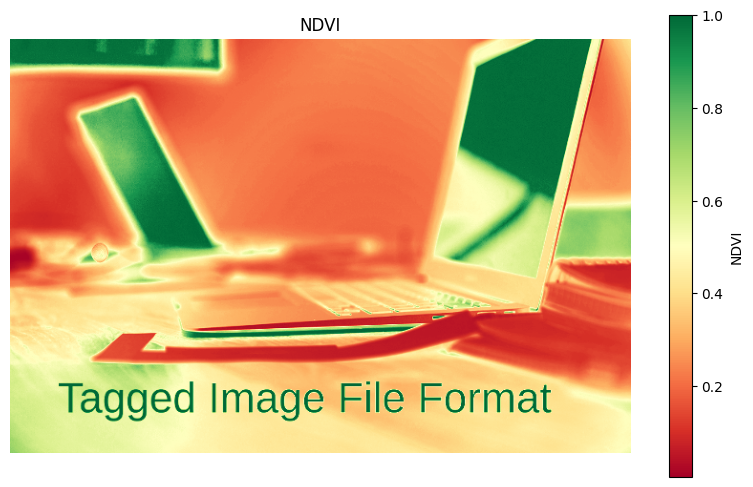

In [16]:
plt.figure(figsize=(10,6))
ndvi_plot = plt.imshow(ndvi, cmap='RdYlGn')  # green = high NDVI
plt.colorbar(ndvi_plot, label='NDVI')
plt.title('NDVI')
plt.axis('off')
plt.show()

#### Histogram

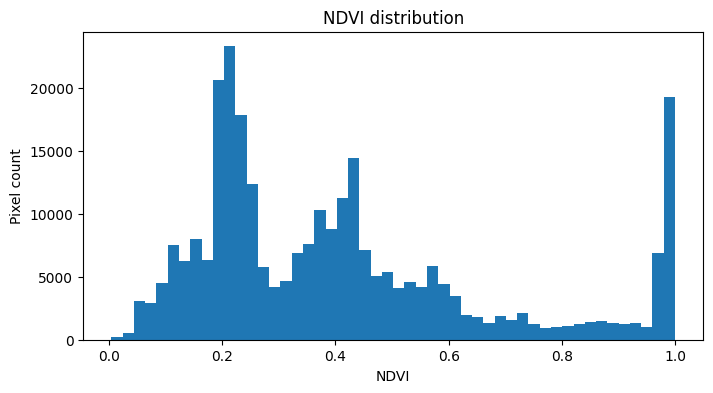

In [17]:
plt.figure(figsize=(8,4))
plt.hist(ndvi[~np.isnan(ndvi)].ravel(), bins=50)
plt.title('NDVI distribution')
plt.xlabel('NDVI')
plt.ylabel('Pixel count')
plt.show()

In [18]:
ndvi_path = "ndvi.tiff"
out_profile = profile.copy()
out_profile.update(dtype=rasterio.float32, count=1, compress='lzw')

with rasterio.open(ndvi_path, 'w', **out_profile) as dst:
    dst.write(ndvi.astype(rasterio.float32), 1)

print("Saved NDVI to:", ndvi_path)

Saved NDVI to: ndvi.tiff


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


### Simple land-use classification by NDVI thresholds

#### Basic idea:

`NDVI < 0 : water / non-vegetated`

`NDVI 0–0.2 : barren/urban`

`NDVI 0.2–0.5 : sparse vegetation / shrubs / crops`

`NDVI > 0.5 : dense vegetation / forest`

These thresholds are example values — adapt to your region/sensor.

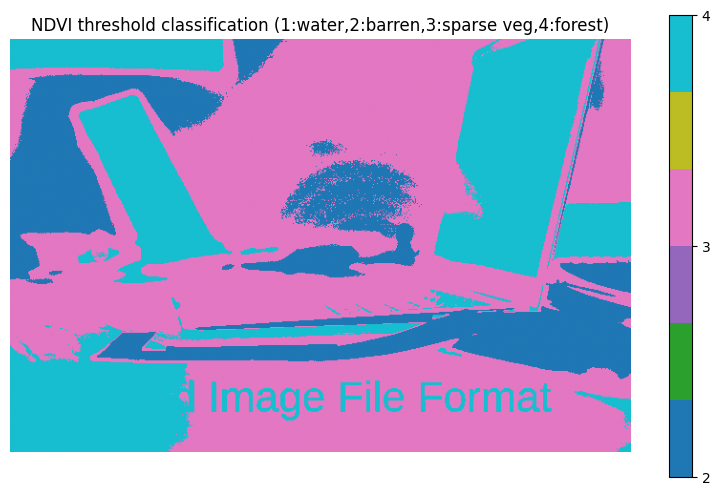

In [19]:
def ndvi_to_classes(ndvi_array):
    classes = np.full(ndvi_array.shape, 255, dtype=np.uint8)  # 255 = nodata / unknown

    classes[np.isnan(ndvi_array)] = 255
    classes[(ndvi_array < 0)] = 1    # class 1 = water / non-veg
    classes[(ndvi_array >= 0) & (ndvi_array < 0.2)] = 2   # barren / urban
    classes[(ndvi_array >= 0.2) & (ndvi_array < 0.5)] = 3  # sparse veg / crops
    classes[(ndvi_array >= 0.5)] = 4   # dense veg / forest
    return classes

ndvi_classes = ndvi_to_classes(ndvi)

# Visualize
cmap = plt.get_cmap('tab10', 6)  # discrete colors
plt.imshow(ndvi_classes, cmap=cmap)
plt.title("NDVI threshold classification (1:water,2:barren,3:sparse veg,4:forest)")
plt.colorbar(ticks=[1,2,3,4])
plt.axis('off')
plt.show()

### Unsupervised classification: k-means using spectral bands or NDVI

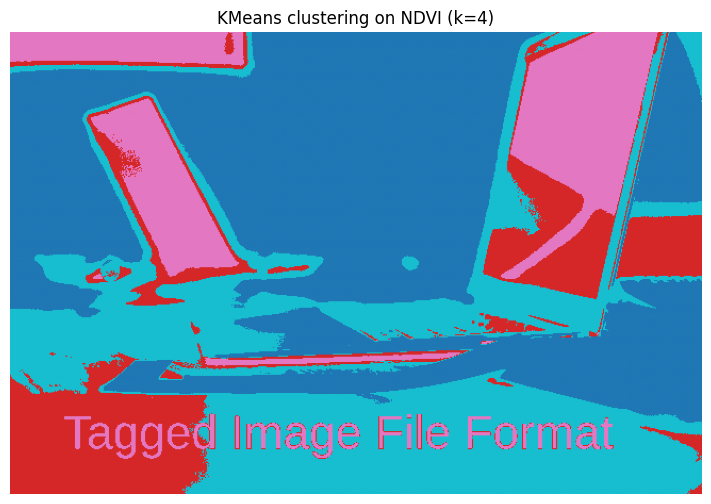

In [20]:
# prepare 1D array of NDVI pixels (mask NaNs)
mask = ~np.isnan(ndvi)
ndvi_vals = ndvi[mask].reshape(-1, 1)

k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(ndvi_vals)

# create full image labels
kmeans_image = np.full(ndvi.shape, 255, dtype=np.uint8)
kmeans_image[mask] = kmeans_labels + 1  # make labels 1..k

plt.imshow(kmeans_image, cmap='tab10')
plt.title(f'KMeans clustering on NDVI (k={k})')
plt.axis('off')
plt.show()

#### If you want to use multiple bands (e.g., red, nir, green):

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


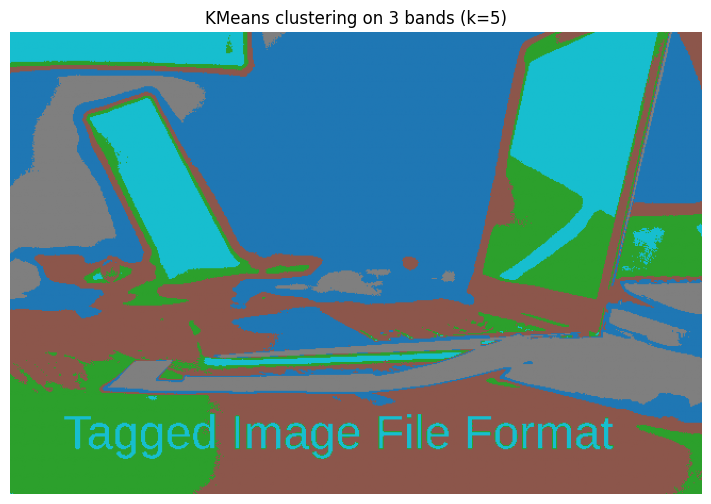

In [21]:
with rasterio.open(raster_path) as src:
    # read example bands (change indices as needed)
    b_red = src.read(red_band_index).astype('float32')
    # suppose green = band 3 (change per dataset)
    b_green = src.read(3).astype('float32') if src.count >= 3 else None
    b_nir = src.read(nir_band_index).astype('float32')

# Stack bands for clustering (only use valid pixels)
if b_green is not None:
    stack = np.stack([b_red, b_green, b_nir], axis=-1)
else:
    stack = np.stack([b_red, b_nir], axis=-1)

# mask invalid (e.g., zero or nodata)
valid_mask = np.any(stack != 0, axis=-1)
X = stack[valid_mask].reshape(-1, stack.shape[-1])

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
km_labels = kmeans.fit_predict(X)

km_image = np.full(stack.shape[:2], 255, dtype=np.uint8)
km_image[valid_mask] = km_labels + 1

plt.imshow(km_image, cmap='tab10')
plt.title(f'KMeans clustering on {stack.shape[-1]} bands (k={k})')
plt.axis('off')
plt.show()


### Supervised classification (Random Forest) using training polygons

This section shows how to:

Provide training polygons and class labels (GeoPandas).

Rasterize / extract pixel samples inside polygons.

Train RandomForest on spectral features (red, nir, ndvi, etc.).

Predict whole image.

**Important**: You need training polygons with known labels (e.g., drawn in QGIS and exported to GeoJSON). For a quick demo we create a few synthetic polygons.

In [22]:
# Example: create three small polygons in image CRS as training areas.
# NOTE: in practice you should create accurate polygons in QGIS and load them with gpd.read_file("train_polygons.geojson")
with rasterio.open(raster_path) as src:
    img_bounds = src.bounds
    img_crs = src.crs

# Create simple polygons within image bounds (for demo only)
minx, miny, maxx, maxy = img_bounds
# small boxes (these are arbitrary and may or may not overlap real classes on your image)
poly1 = Polygon([(minx+(maxx-minx)*0.05, miny+(maxy-miny)*0.05),
                 (minx+(maxx-minx)*0.15, miny+(maxy-miny)*0.05),
                 (minx+(maxx-minx)*0.15, miny+(maxy-miny)*0.15),
                 (minx+(maxx-minx)*0.05, miny+(maxy-miny)*0.15)])
poly2 = Polygon([(minx+(maxx-minx)*0.7, miny+(maxy-miny)*0.05),
                 (minx+(maxx-minx)*0.85, miny+(maxy-miny)*0.05),
                 (minx+(maxx-minx)*0.85, miny+(maxy-miny)*0.18),
                 (minx+(maxx-minx)*0.7, miny+(maxy-miny)*0.18)])
poly3 = Polygon([(minx+(maxx-minx)*0.4, miny+(maxy-miny)*0.6),
                 (minx+(maxx-minx)*0.55, miny+(maxy-miny)*0.6),
                 (minx+(maxx-minx)*0.55, miny+(maxy-miny)*0.75),
                 (minx+(maxx-minx)*0.4, miny+(maxy-miny)*0.75)])

gdf = gpd.GeoDataFrame({
    'class_id': [1, 2, 3],   # class labels (you define)
    'class_name': ['water', 'urban', 'forest'],
    'geometry': [poly1, poly2, poly3]
}, crs=img_crs)

gdf

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


,class_id,class_name,geometry
0,1,water,"POLYGON ((32.5 412.3, 97.5 412.3, 97.5 368.9, ..."
1,2,urban,"POLYGON ((455 412.3, 552.5 412.3, 552.5 355.88..."
2,3,forest,"POLYGON ((260 173.6, 357.5 173.6, 357.5 108.5,..."


#### Rasterize training polygons and sample features (spectral bands + NDVI):

In [23]:
from rasterio.features import rasterize

# Prepare stack of features (red, nir, ndvi) in same shape
with rasterio.open(raster_path) as src:
    rb = src.read(red_band_index).astype('float32')
    nb = src.read(nir_band_index).astype('float32')
    transform = src.transform
    height, width = rb.shape

ndvi_full = (nb - rb) / (nb + rb)
ndvi_full = np.where((nb + rb) == 0, np.nan, ndvi_full)

# Create 3-band feature stack
features_stack = np.dstack([rb, nb, ndvi_full])

# Rasterize training polygons into same spatial grid, using class_id as value
shapes = ((mapping(geom), value) for geom, value in zip(gdf.geometry, gdf.class_id))
train_mask = rasterize(shapes=shapes, out_shape=(height, width), transform=transform, fill=0, dtype='uint8')

# Extract training pixels
train_pixels = features_stack[train_mask > 0]  # shape (n_samples, n_features)
train_labels = train_mask[train_mask > 0]

print("Training samples:", train_pixels.shape, "Labels:", np.unique(train_labels))

Training samples: (14751, 3) Labels: [1 2 3]


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


#### Train RandomForest:

In [24]:
# Remove nan rows (e.g., where ndvi is nan)
valid = ~np.isnan(train_pixels).any(axis=1)
X_train = train_pixels[valid]
y_train = train_labels[valid]

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Random Forest trained.")

X_train shape: (14751, 3) y_train shape: (14751,)
Random Forest trained.


#### Predict full image:

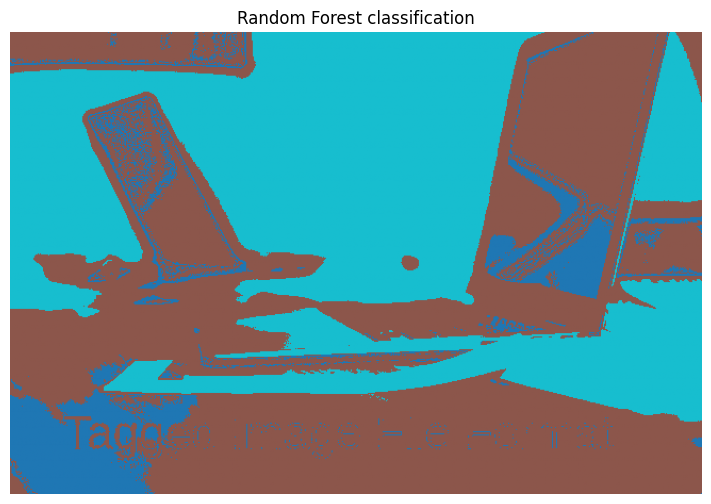

In [25]:
# Flatten features for prediction
flat_features = features_stack.reshape(-1, features_stack.shape[-1])
valid_pixels = ~np.isnan(flat_features).any(axis=1)

pred = np.full(flat_features.shape[0], 255, dtype=np.uint8)  # default nodata/unknown
pred[valid_pixels] = rf.predict(flat_features[valid_pixels]).astype(np.uint8)

pred_image = pred.reshape(height, width)

plt.imshow(pred_image, cmap='tab10')
plt.title("Random Forest classification")
plt.axis('off')
plt.show()

## Testing NDVI with a Real Dataset in Indiana

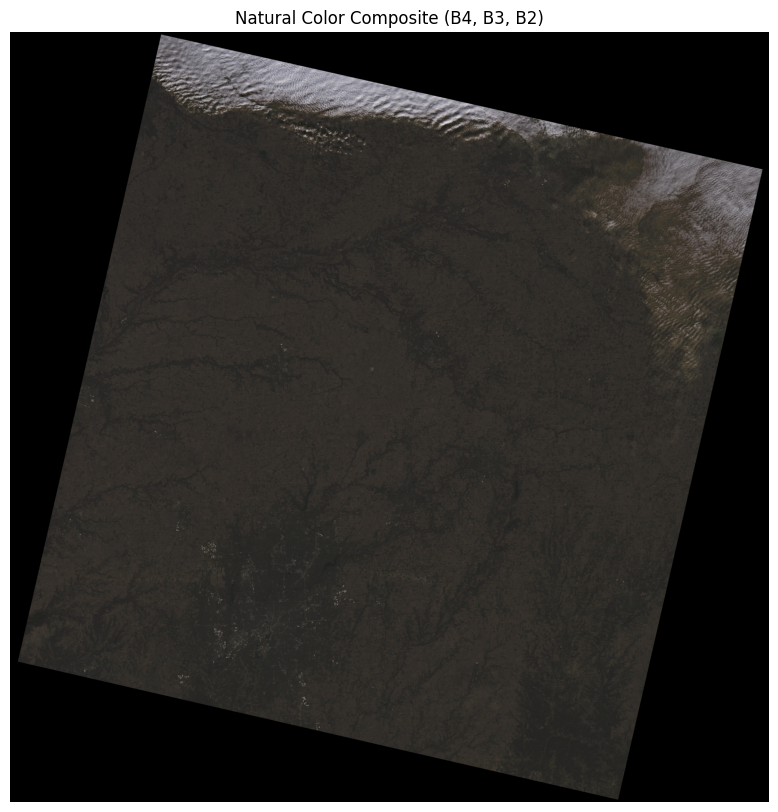

In [9]:
red_path = "band4.TIF"
green_path = "band3.TIF"
blue_path = "band2.TIF"

# Open each band
with rasterio.open(red_path) as src_red:
    red = src_red.read(1)
with rasterio.open(green_path) as src_green:
    green = src_green.read(1)
with rasterio.open(blue_path) as src_blue:
    blue = src_blue.read(1)

# Normalize bands to 0-255 if they are not already (assuming 16-bit or similar input)
# Find max value across all bands to normalize consistently
max_val = np.max([red.max(), green.max(), blue.max()])

# Avoid division by zero if max_val is 0
if max_val > 0:
    red_norm = (red / max_val * 255).astype(np.uint8)
    green_norm = (green / max_val * 255).astype(np.uint8)
    blue_norm = (blue / max_val * 255).astype(np.uint8)
else:
    red_norm = red.astype(np.uint8)
    green_norm = green.astype(np.uint8)
    blue_norm = blue.astype(np.uint8)

# Stack bands to create an RGB image
rgb_image = np.dstack((red_norm, green_norm, blue_norm))

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title('Natural Color Composite (B4, B3, B2)')
plt.axis('off')
plt.show()

In [5]:
# Path to your folder containing the Landsat 9 files

# Red (Band 4) and NIR (Band 5) file paths
red_band_path = "band4.TIF"
nir_band_path = "band5.TIF"

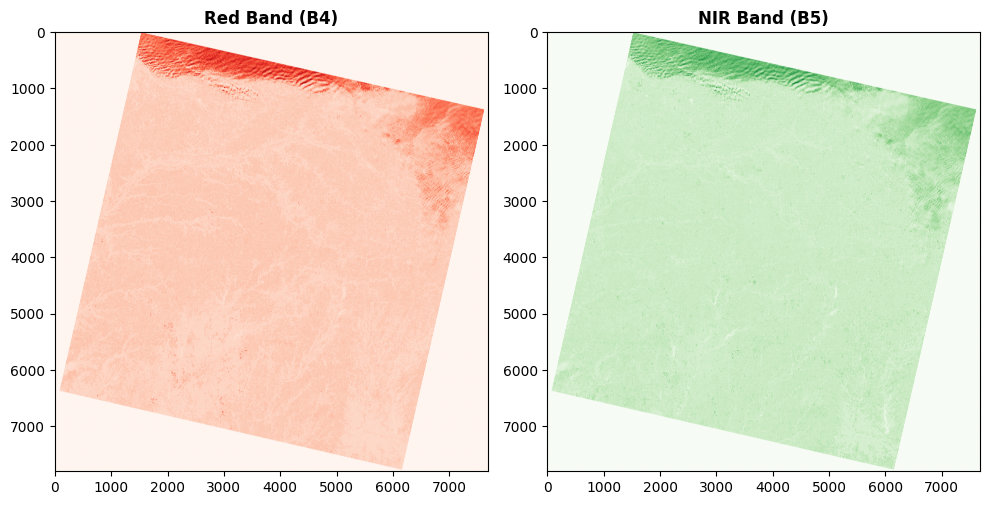

In [6]:
# Open the Red and NIR bands
with rasterio.open(red_band_path) as red_src:
    red = red_src.read(1).astype(float)
    red_meta = red_src.meta

with rasterio.open(nir_band_path) as nir_src:
    nir = nir_src.read(1).astype(float)

# Display both bands
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
show(red, ax=ax1, cmap='Reds', title='Red Band (B4)')
show(nir, ax=ax2, cmap='Greens', title='NIR Band (B5)')
plt.tight_layout()
plt.show()

In [7]:
# Avoid divide-by-zero
np.seterr(divide='ignore', invalid='ignore')

# Compute NDVI
ndvi = (nir - red) / (nir + red)

# Display NDVI summary
print("NDVI Stats:")
print("Min:", np.nanmin(ndvi))
print("Max:", np.nanmax(ndvi))
print("Mean:", np.nanmean(ndvi))

NDVI Stats:
Min: -0.3109338911404541
Max: 1.0
Mean: 0.1312870741898992


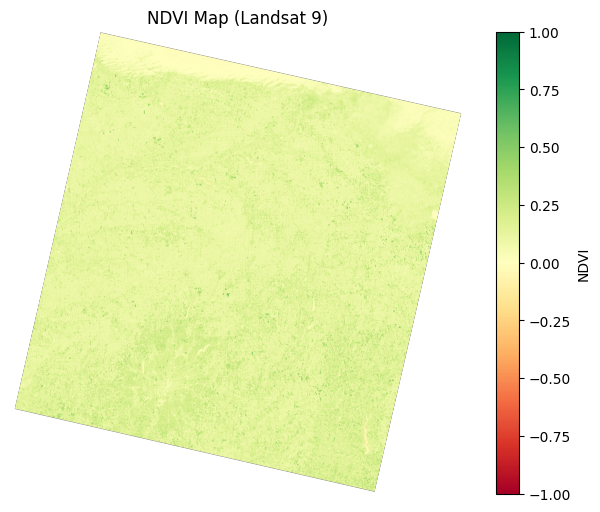

In [8]:
# Display NDVI
plt.figure(figsize=(8, 6))
ndvi_plot = plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(ndvi_plot, label='NDVI')
plt.title('NDVI Map (Landsat 9)')
plt.axis('off')
plt.show()